In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np


import os
print(os.listdir("../input/digitsfinal/maths/"))
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['6', '4', '9', '2', '8', '1', '7', '5', '0', '3']


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
#         rescale=1./255,
#         rotation_range=20,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function = preprocessing,
        validation_split = 0.1,
    )
    
    
    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        '../input/digitsfinal/maths/',
        target_size = (height, width), 
        classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'),
        batch_size = batch_size,
        subset = 'training', 
    )

    val_dataset = imgdatagen.flow_from_directory(
        '../input/digitsfinal/maths/',
        target_size = (height, width), 
        classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'),
        batch_size = batch_size,
        subset = 'validation'
    )
    return train_dataset, val_dataset

In [17]:
vgg = keras.applications.vgg16

In [18]:
train_dataset, val_dataset = generators((256,256), preprocessing=vgg.preprocess_input)

Found 6894 images belonging to 10 classes.
Found 763 images belonging to 10 classes.


In [19]:
vgg_conv = vgg.VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [20]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f2f781aaf10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2f781aaf50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2f6022cb90> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f2f78263f50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2f781a72d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2f68054190> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f2f6022a150> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2f781adf10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2f680354d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2f601e0090> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f2f601d9510> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [21]:
# Create the model
model = keras.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 48,280,394
Trainable params: 40,645,130
Non-trainable params: 7,635,264
_________________________________________________________________


In [22]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("../working/model.h5", monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=1e-4),
              metrics=['acc'])
# Train the model
history = model.fit_generator(
      train_dataset,
      steps_per_epoch=train_dataset.samples/batch_size ,
      epochs=20,
      validation_data=val_dataset,
      validation_steps=val_dataset.samples/batch_size,
      verbose=1,
      callbacks=[checkpoint])

Epoch 1/20
216/215 [==============================] - ETA: 0s - loss: 0.4773 - acc: 0.9169
Epoch 00001: val_acc improved from -inf to 0.98034, saving model to ../working/model.h5
216/215 [==============================] - 50s 231ms/step - loss: 0.4773 - acc: 0.9169 - val_loss: 0.1529 - val_acc: 0.9803
Epoch 2/20
216/215 [==============================] - ETA: 0s - loss: 0.0970 - acc: 0.9822
Epoch 00002: val_acc improved from 0.98034 to 0.98952, saving model to ../working/model.h5
216/215 [==============================] - 39s 181ms/step - loss: 0.0970 - acc: 0.9822 - val_loss: 0.0412 - val_acc: 0.9895
Epoch 3/20
216/215 [==============================] - ETA: 0s - loss: 0.0524 - acc: 0.9910
Epoch 00003: val_acc did not improve from 0.98952
216/215 [==============================] - 37s 171ms/step - loss: 0.0524 - acc: 0.9910 - val_loss: 0.1179 - val_acc: 0.9856
Epoch 4/20
216/215 [==============================] - ETA: 0s - loss: 0.1125 - acc: 0.9872
Epoch 00004: val_acc improved from 

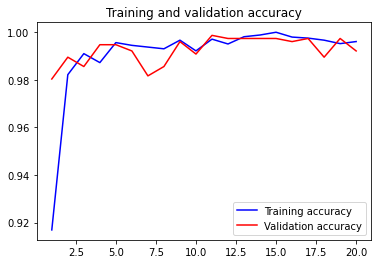

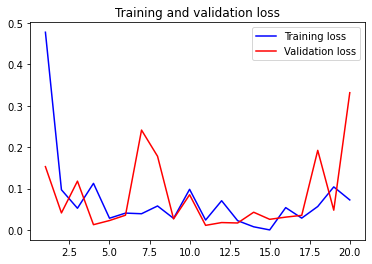

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
# plt.savefig('Accuracy.jpg')
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# plt.savefig('Loss.jpg')
